In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [89]:
Npix = 100
Nmax = 1000
wavelength = 500*10**(-9)
umax = 3*10**8
freq = 6*10**14
c = 3*10**9
ep_o = 8.85*10**(-12)
mu_o = 12.57*10**(-7)
wavelength = dt = ep_o = mu_o = c = umax = freq = 1

#dx = dy = dz = wavelength/100
#dt = dx/(umax*np.sqrt(3))

dx = dy = dz = 0.1
dt = 0.01
R = dt/(2*ep_o)
Ra = (c*dt/dx)**2
Rb = dt/(mu_o*dx)

#Ex = Ey = Ez = Hx = Hy = Hz = np.zeros((Npix,Npix))

sig_types = [1,1,1]
ep_r_types = [1,1,1]
media = np.zeros((Npix,Npix,Npix))
media[:,:,:int(Npix/3)] = 0
media[:,:,int(Npix/3):int(2*Npix/3)] = 1
media[:,:,int(2*Npix/3):] = 2

sigma = sig_types[0]*(media == 0) + sig_types[1]*(media == 1) + sig_types[2]*(media == 2)
ep_r = ep_r_types[0]*(media == 0) + ep_r_types[1]*(media == 1) + ep_r_types[2]*(media == 2)
Ca = (1 - (R*sigma/ep_r))/(1 + (R*sigma/ep_r))
Cb = Ra/(ep_r + R*sigma)

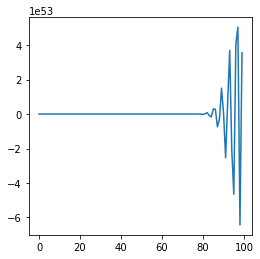

In [90]:
# Initialize
E = H = np.zeros((Npix,Npix,Npix,3))

# initial conditions
x = dx*np.array(range(Npix))
y = dy*np.array(range(Npix))
z = dz*np.array(range(Npix))
#x,y = np.array(np.meshgrid(x,y))
E[:,Npix//5,int(Npix/2),2] = np.sin(50*x/(Npix*dx))#*np.sin(50*y[2:5]/(Npix*dy))
H[:,Npix//5,int(Npix/2),1] = np.sin(50*x/(Npix*dx))#*np.sin(50*y[2:5]/(Npix*dy))

# Define x and y array and find center of grid cx, cy
cx = dx*Npix//2
cy = dy*Npix//2
cz = dz*Npix//2

# Define temporary scattering object condition
bc = np.ones((Npix,Npix,Npix))

# Define sphere as scattering object
radius = dx*Npix/4
mask = (x[np.newaxis,:]-cx)**2 + (y[:,np.newaxis]-cy)**2 + (z[:,np.newaxis]-cz)**2 <= radius**2
bc[mask] = 0


for n in range(Nmax):

    E_temp = H_temp = np.zeros((Npix,Npix,Npix,3))
    
    for i in range(3):
        # This sets the E and H fields to 0 within and on boundary of scattering object
        E[:,:,:,i] *= bc
        H[:,:,:,i] *= bc
    # 3.93 a)
    H_temp[:,:,:,0] = H[:,:,:,0] + Rb*np.roll(E[:,:,:,1],-1,axis=2) - E[:,:,:,1] - np.roll(E[:,:,:,2],-1,axis=1) + E[:,:,:,2]
    # 3.93 b)
    H_temp[:,:,:,1] = H[:,:,:,1] + Rb*np.roll(E[:,:,:,2],-1,axis=0) - E[:,:,:,2] - np.roll(E[:,:,:,0],-1,axis=2) + E[:,:,:,0]
    # 3.93 c)
    H_temp[:,:,:,2] = H[:,:,:,2] + Rb*np.roll(E[:,:,:,0],-1,axis=1) - E[:,:,:,0] - np.roll(E[:,:,:,1],-1,axis=0) + E[:,:,:,1]
    # 3.93 d)
    E_temp[:,:,:,0] = Ca*E[:,:,:,0] + Cb/Rb*(H[:,:,:,2] - np.roll(H[:,:,:,2],1,axis=1) - H[:,:,:,1] + np.roll(H[:,:,:,1],1,axis=2))
    # 3.93 e)
    E_temp[:,:,:,1] = Ca*E[:,:,:,1] + Cb/Rb*(H[:,:,:,0] - np.roll(H[:,:,:,0],1,axis=2) - H[:,:,:,2] + np.roll(H[:,:,:,2],1,axis=0))
    # 3.93 f)
    E_temp[:,:,:,2] = Ca*E[:,:,:,2] + Cb/Rb*(H[:,:,:,1] - np.roll(H[:,:,:,1],1,axis=1) - H[:,:,:,0] + np.roll(H[:,:,:,0],1,axis=1))
    
    # For i = 1/2 plane
    H_temp[0,:,:,1] = 1/3*(np.roll(H[2,:,:,1],2,axis=1) + H[2,:,:,1] + np.roll(H[2,:,:,1],-2,axis=1))
    
    H_temp[0,:,:,2] = 1/3*(np.roll(H[2,:,:,2],2,axis=1) + H[2,:,:,2] + np.roll(H[2,:,:,2],-2,axis=1))
    
    # For plane i = Imax+1/2
    H_temp[-1,:,:,1] = 1/3*(np.roll(H[-2,:,:,1],2,axis=1) + H[-2,:,:,1] + np.roll(H[-2,:,:,1],-2,axis=1))
    H_temp[-1,:,:,2] = 1/3*(np.roll(H[-2,:,:,2],2,axis=1) + H[-2,:,:,2] + np.roll(H[-2,:,:,2],-2,axis=1))
    
    # For plane j = 0
    E_temp[:,0,:,0] = E[:,2,:,0]
    E_temp[:,0,:,2] = E[:,2,:,2]
    
    # For plane j= Jmax
    E_temp[:,-1,:,0] = E[:,-3,:,0] 
    E_temp[:,-1,:,2] = E[:,-3,:,2] 
    
    # For k = 0
    E_temp[:,:,0,0] = 1/3*(np.roll(E[:,:,2,0],2,axis=0) + E[:,:,2,0] + np.roll(E[:,:,2,0],-2,axis=0))
    E_temp[:,:,0,1] = 1/3*(np.roll(E[:,:,2,1],2,axis=0) + E[:,:,2,1] + np.roll(E[:,:,2,1],-2,axis=0))
    
    # For plane k = Kmax
    E_temp[:,:,-1,0] = 1/3*(np.roll(E[:,:,-3,0],2,axis=0) + E[:,:,-3,0] + np.roll(E[:,:,-3,0],-2,axis=0))
    E_temp[:,:,-1,1] = 1/3*(np.roll(E[:,:,-3,1],2,axis=0) + E[:,:,-3,1] + np.roll(E[:,:,-3,1],-2,axis=0))
    
    E=E_temp
    H=H_temp
    
    
    x = dx*np.array(range(Npix))
    y = dy*np.array(range(Npix))
    x,y = np.array(np.meshgrid(x,y))
    z = E[:,:,int(Npix/2),2]
    #ax.plot_surface(x,y,z)
    
    #plt.plot(E[Npix//2,:,Npix//2,2])
    #plt.show()
    #plt.pause(0.01)
#plt.savefig("plot.png")
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
plt.plot(E[Npix//2,:,Npix//2,2])
plt.show()